# 导包

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import random
import os
from sklearn import metrics
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import StratifiedKFold, KFold

import torch
from torch import nn, optim

from torchvision import datasets, transforms

import albumentations as A
import cv2
import gc


/opt/anaconda3/envs/pytorch_junsheng_39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1.12.0
True
2
NVIDIA GeForce RTX 3090


# wandb

In [3]:
import wandb

try:
    # wandb.log(key="*******") # if debug
    wandb.login() # storage in ~/.netrc file
    anonymous = None
except:
    anonymous = "must"
    print('\nGet your W&B access token from here: https://wandb.ai/authorize\n')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bujidao. Use `wandb login --relogin` to force relogin


# config

In [4]:
torch.backends.cudnn.enabled = False #禁用cudnn
class config:
    debug = True
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    root_path = r'/home/junsheng/huawei'
    # root_path = r'E:\Download'
    project = 'huawei_contest'
    img_size = (512,512)
    seed = 666
    train_batch_size = 16
    test_batch_size = 16
    lr = (2e-3)/2
    epoch = 3
    n_fold = 5
    #wandb
    model_name = 'efficientnet-b4'
    wandb_group = "junsheng"
    wandb_offline = True
    path_to_save = "./runs"
    
###########################
if config.debug:
    print("当前为调试模式!")
    config.train_batch_size = 16
    config.test_batch_size = 16
    config.epoch = 5
    config.img_size = (512,512)
    config.wandb_group = "junsheng_debug"
    config.project = 'huawei_contest_debug'
    config.model_name = 'efficientnet-b4'
###########################
if config.wandb_offline:
    os.environ["WANDB_MODE"] = "offline"
def set_seed(seed = config.seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
set_seed(config.seed)
config.device    

当前为调试模式!
> SEEDING DONE


device(type='cuda', index=1)

# 数据集准备

## 数据信息

数据总量： 29164


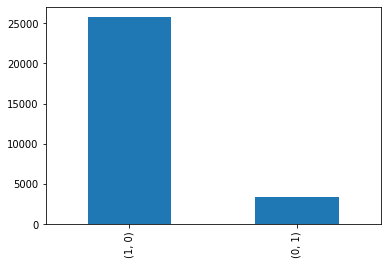

In [5]:
train_label_path = os.path.join(config.root_path,'./train_label/my_train_label.csv')
df = pd.read_csv(train_label_path)
df = df[['pic','label']]
def change(x):
    if x == 0:
        return (1,0)
    else:
        return (0,1)
df['oh_label'] = df.label.astype(int).map(change)
df.oh_label.value_counts().plot.bar()
print("数据总量：",df.oh_label.value_counts().sum())

<AxesSubplot:>

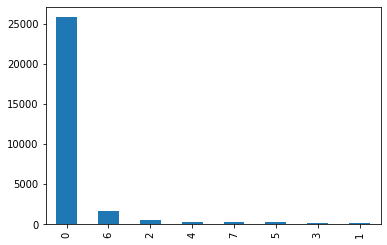

In [6]:
df.label.value_counts().plot.bar()

In [7]:
df.head()

,pic,label,oh_label
0,train_00000.png,1,"(0, 1)"
1,train_00001.png,0,"(1, 0)"
2,train_00002.png,0,"(1, 0)"
3,train_00003.png,0,"(1, 0)"
4,train_00004.png,0,"(1, 0)"


## 创建fold

In [8]:
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

## 生成标签

In [9]:

import csv
file=[]
number=[]
train_label_path = os.path.join(config.root_path,'./train_label/train_label.csv') if config.debug else os.path.join(config.root_path,'./train_label/label.csv')

with open(train_label_path) as csvfile:
    csv_reader = csv.reader(csvfile)  # 使用csv.reader读取csvfile中的文件
    for row in csv_reader:            # 将csv 文件中的数据保存到data中
        file.append(row[0])           # 选择某一列加入到data数组中
        if(row[1]=="0"):
            number.append([1,0])
        else:
            number.append([0,1])
number=torch.tensor(number, dtype=torch.float)
print(number.shape)

torch.Size([29164, 2])


In [10]:
file = [os.path.join(config.root_path,"./train_image/labeled_data/",i) for i in file ]
print(len(file))

29164


In [11]:
from PIL import Image
import matplotlib.pyplot as plt
print(number[1]+number[2])
print(number)

tensor([2., 0.])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])


## 数据增强

In [12]:
data_transforms = {
    "train": A.Compose([
        # A.Resize(config.img_size[0],config.img_size[1], interpolation=cv2.INTER_NEAREST),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        # A.OneOf([
            # A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        # ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "test": A.Compose([
        # A.Resize(config.img_size[0],config.img_size[1], interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [13]:
channel_mean = torch.tensor([0.7136, 0.7118, 0.6788])
channel_std = torch.tensor([0.3338, 0.3453, 0.3020])
# 这是反归一化的 mean 和std 
MEAN = [-mean/std for mean, std in zip(channel_mean, channel_std)]
STD = [1/std for std in channel_std]

# 归一化和反归一化生成器
normalizer = transforms.Normalize(mean=channel_mean, std=channel_std)
denormalizer = transforms.Normalize(mean=MEAN, std=STD)

## dataset

In [14]:
number_train = number[:50] if config.debug else number[:]
number_test = number[:50] if config.debug else number[:]

file_train = file[:50] if config.debug else file[:]
file_test = file[:50] if config.debug else file[:]


myTransforms = transforms.Compose([
    transforms.Resize(config.img_size),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.7136, 0.7118, 0.6788],
    std=[0.3338, 0.3453, 0.3020],
    
)
])

def image_loader(path):
    # img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # img = img[:,:,3]
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = img.astype('float32')
    img =  Image.open(path).convert('RGB')
    img = myTransforms(img)
    return img


class my_dataset(Dataset):
    def __init__(self, loader=image_loader,A_transforms=None):
        self.images = file_train
        self.target = number_train
        self.loader = loader
        self.A_transforms = A_transforms

    def __getitem__(self, index):
        fn = self.images[index]
        img = self.loader(fn)
        if self.A_transforms:
            data = self.A_transforms(image=img)
            img  = data['image']
        # img = img.transpose(2,0,1)
        # img = normalizer(torch.tensor(img))        # 归一化
        # img = normalizer(img.clone().detach())        # 归一化
        target = self.target[index].cuda()
        # return img.clone().detach(),target.clone().detach()
        return img,target

    def __len__(self):
        return len(self.images)
    

    


## Dataloader

Dataloader Define

In [15]:
train_data  = my_dataset(A_transforms=data_transforms['train'])
test_data = my_dataset(A_transforms=data_transforms['test'])

train_loader = DataLoader(train_data, batch_size=config.train_batch_size,shuffle=True)
testloader = DataLoader(test_data, batch_size=config.test_batch_size,shuffle=False)


### mean std 

In [16]:

def get_mean_std_value(loader):
    '''
    求数据集的均值和标准差
    :param loader:
    :return:
    '''
    data_sum,data_squared_sum,num_batches = 0,0,0
    
    for data,_ in loader:
        # data: [batch_size,channels,height,width]
        # 计算dim=0,2,3维度的均值和，dim=1为通道数量，不用参与计算
        # data_sum += torch.mean(data,dim=[0,2,3])    # [batch_size,channels,height,width]
        data_sum += torch.mean(data,dim=[0,1,2])    # [batch_size,height,width,channels]
        # 计算dim=0,2,3维度的平方均值和，dim=1为通道数量，不用参与计算
        # data_squared_sum += torch.mean(data**2,dim=[0,2,3])  # [batch_size,channels,height,width]
        data_squared_sum += torch.mean(data**2,dim=[0,1,2])  # [batch_size,height,width,channels]
        # 统计batch的数量
        num_batches += 1

       
    # 计算均值
    mean = data_sum/num_batches
    # 计算标准差
    std = (data_squared_sum/num_batches - mean**2)**0.5
    return mean,std

# mean,std = get_mean_std_value(train_loader)
# print('mean = {},std = {}'.format(mean,std))
# mean = tensor([181.9735, 181.5179, 173.0954]),std = tensor([85.1068, 88.0633, 77.0048])
# mean:tensor([0.7136, 0.7118, 0.6788])
# std:tensor([0.3338, 0.3453, 0.3020]) ->batch_size,height,width

### 可视化

In [17]:
def plot_batch(imgs, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = denormalizer(torch.tensor(imgs[idx,]))# 反归一化得到原图
        img = img.permute((1,2,0)).numpy()*255
        print("imgs[0].shape:",imgs[0].shape,"->img.shape:",img.shape)
        img = img.astype('uint8')
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

imgs[0].shape: torch.Size([3, 512, 512]) ->img.shape: (512, 512, 3)


/tmp/ipykernel_1226424/671165804.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = denormalizer(torch.tensor(imgs[idx,]))# 反归一化得到原图


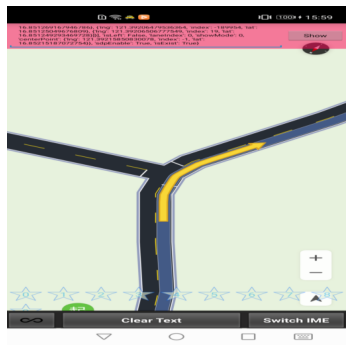

In [18]:
imgs,lable = next(iter(train_loader))
imgs.size(), lable.size()
plot_batch(imgs, size=1)

# 模型准备

resnet

In [19]:
import pretrainedmodels
#model_name = 'resnext101_32x4d'
# model_name = 'resnet18'
#model_name = 'resnet18' # could be fbresnet152 or inceptionresnetv2

def build_model_resnet():
    '''
    from torchvision import models
    model = models.resnet18(pretrained=False)

    params = torch.load("model18.pth") # 加载参数
    model.load_state_dict(params) # 应用到网络结构中

    NUM_CLASS = 80                       #种类数，即最后预测结果的维度
    in_fc_nums = model.fc.in_features    #resnet18最后一层输入神经元的个数
    fc = nn.Linear(in_fc_nums,NUM_CLASS)
    model.fc = fc

    '''
    model = pretrainedmodels.__dict__[config.model_name](num_classes=1000, pretrained='imagenet')
    dim_feats = model.last_linear.in_features # =2048
    nb_classes = 2
    model.last_linear = nn.Linear(dim_feats, nb_classes)
    return   model


efficientnet

In [20]:
# refer:https://github.com/lukemelas/EfficientNet-PyTorch#example-classification
from efficientnet_pytorch import EfficientNet
def build_model_efficient():
    nb_classes = 2
    model = EfficientNet.from_pretrained(config.model_name)# 'efficientnet-b4'
    model._fc = nn.Linear(1792, 2)
    return model
# hah = build_model_efficient()


In [21]:
# a = torch.rand([1,3,255,255])
# print(a.shape)
# hah(a).shape

In [22]:
# model = build_model_resnet()
model = build_model_efficient()

Loaded pretrained weights for efficientnet-b4


In [23]:
# model(a).shape

# 验证一个epoch

In [24]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    auc_loss = 0.0
    running_auc = 0.0
    val_scores = []
    
    for images, labels in dataloader:        
        images  = images.to(device, dtype=torch.float)
        labels   = labels.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        out  = model(images)
        out=last(out)

        auc = metrics.roc_auc_score(labels.cpu().numpy(), out.cpu().numpy())
        
        
        loss    = criterion(out, labels)
        running_loss += (loss.data.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size    

        val_scores.append(auc)
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores



# 训练

In [25]:
model_file_path = os.path.join(config.root_path,"last_epoch.bin") # 保存模型文件的路径

In [26]:
lr = config.lr
print("学习率: ",lr)
criterion = nn.BCELoss() #交叉熵损失函数
#optimizer = optim.Adam(model.parameters(),lr,weight_decay=5e-4)
optimizer = optim.SGD(model.parameters(), 
                       lr,
                       momentum=0.9)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)


Epoch = config.epoch
print("迭代次数: ",Epoch)
train_loss_all=[]

loss_sum = 0
best_epoch = -1
best_loss = 1e3
# last=nn.Softmax(dim=1) # CE可以用softmax，但是BCE需要用sigmoid
last = nn.Sigmoid()


# init wandb
run = wandb.init(project=config.project, 
                     config={k:v for k, v in dict(vars(config)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"dim-{config.img_size}|model-{config.model_name}",
                     group=config.wandb_group,
                    )
model.to(config.device)

wandb.watch(model, log_freq=100)
for num_epoch in range(Epoch):
    # train epoch>>>
    dataset_size = 0
    running_loss = 0.0
    model.train()
    for data in train_loader:
        img, label = data
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
        out = model(img)
        out=last(out)
        loss = criterion(out, label)#计算损失函数
        running_loss += (loss.data.item() * config.train_batch_size)
        dataset_size += config.train_batch_size
        epoch_loss = running_loss / dataset_size

        #一坨优化
        optimizer.zero_grad()#每一次反向传播之前都要归零梯度
        loss.backward()      #反向传播
        optimizer.step()     #固定写法
        lr_scheduler.step()
    with torch.no_grad():
        model.eval()       
        outs = []
        labels = []
        for datat in testloader:
            img, label = datat    
            if torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()
                out = model(img)
                out=last(out)

                labels.extend(label.cpu().numpy())
                outs.extend(out.cpu().numpy())
                
        auc = metrics.roc_auc_score(labels, outs)
    print('epoch: {}, loss: {:.4},auc:{}'.format(num_epoch + 1, epoch_loss,auc))
    train_loss_all.append(epoch_loss)
    # find a better
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = num_epoch + 1

        run.summary["Best Epoch"]   = best_epoch
        run.summary["Best Loss"]   = best_loss

        torch.save(model.state_dict(), model_file_path)
        print("model save to",model_file_path)
        wandb.save()
    # Log the metrics
    wandb.log({"Train Loss": epoch_loss,
                "Valid AUC":auc
    })
    gc.collect()

# run.finish() 


学习率:  0.001
迭代次数:  5


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

: 

# 推理

In [ ]:
from edafa import ClassPredictor
from edafa import ClassPredictor

class myPredictor(ClassPredictor):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.model = model
        
        
    def predict_patches(self,patches):
        preds = []
        for i in range(patches.shape[0]):
            processed = patches[i].unsqueeze(0)
            pred = self.model(processed)
            preds.append(pred.data.numpy())

        return np.array(preds)

In [ ]:
# transform_pipeline = transforms.Compose()
# ans=[]
# model = model 
# model.load_state_dict(torch.load(model_file_path))
# model.eval()
# model.to(config.device)
# # for i in range(1,4001):
# rows = 51 if config.debug else 4001
# for i in range(1,rows):
#     path= os.path.join(config.root_path,"test_images","test_"+str(i).zfill(5)+".png")
#     img = image_loader(path)
#     data = data_transforms['test'](image=img)
#     img  = data['image']
#     img = img.transpose(2,0,1)
#     img = normalizer(torch.tensor(img)) 

#     p = myPredictor(model,transform_pipeline,"../../conf/imagenet.json")
#     img = img.unsqueeze(0).cuda()

#     out = p.predict_images(img)
#     out = torch.from_numpy(out)
#     # out = model(img)
#     n=nn.Softmax(dim=0)
#     idx = n(out[0])  
#     ans.append(idx[1].item())

In [ ]:
ans=[]
model = model 
model.load_state_dict(torch.load(model_file_path))
model.eval()
model.to(config.device)
# for i in range(1,4001):
rows = 51 if config.debug else 4001
for i in range(1,rows):
    path= os.path.join(config.root_path,"test_images","test_"+str(i).zfill(5)+".png")
    img = image_loader(path)
    # data = data_transforms['test'](image=img)
    # img  = data['image']
    # img = img.transpose(2,0,1)
    # img = normalizer(torch.tensor(img)) # torch.Size([3, 512, 512])
    
    img = img.unsqueeze(0).cuda() # torch.Size([1, 3, 512, 512])
    out = model(img)  # torch.Size([1, 2])
    n=nn.Softmax(dim=0)
    idx = n(out[0])  
    ans.append(idx[1].item())

## 提交文件

In [ ]:
with open("submission.csv","w") as csvfile: 
    writer = csv.writer(csvfile)

    #先写入columns_name
    writer.writerow(["imagename","defect_prob"])
    #写入多行用writerows
    for i in range(1,rows):
        writer.writerow(["test_"+str(i).zfill(5)+".png",float(ans[i-1])])
print("result to submission.csv")
        


result to submission.csv


In [ ]:
wandb.save(model_file_path)
wandb.save("submission.csv")
wandb.save("train.ipynb")